# Jupyter notebook to generate the data and plot Figure 3 and S4 and S5 in "Heat extremes driven by amplification of phase-locked circumglobal waves forced by topography in an idealized atmospheric model" by B. Jimenez-Esteve, K. Kornhuber and D. I.V. Domeisen

Author: Bernat Jimenez-Esteve (ETH Zurich) Last update: October 2022

The notebook blocks need to be executed sequencially in order to be able to reproduce the same Figures as in the paper.

The netCDF files containing the processed model data need to be loacted in the local data directory and can be downloaded from the following repository:

In [1]:
#load main modeules
import xarray as xr
import numpy as np

# Model data loading 

Chose only one model run to process each time. First we need amplitudes.

In [4]:
root='data/wave_amplitudes/'

#amp_mnt = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').amplitudes
#amp_mnt = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_4km_45N.nc').amplitudes
#amp_mnt = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_45N.nc').amplitudes
amp_mnt = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_25N.nc').amplitudes

In [5]:
#T1000 and V300

#Read ICON data (select just one run at a time)
#f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_4km_45N_daymean.nc'
#f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_8km_45N_daymean.nc'
f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_8km_25N_daymean.nc'

#we reomve the first 3 simulation days to be consistent with the amplitude dataset
v_hs =  xr.open_dataset(f).v300.sel(lat=slice(90,10), time=slice('0001-01-04', '0030-12-30')).load()
z_hs =  xr.open_dataset(f).z300.sel(lat=slice(90,10), time=slice('0001-01-04', '0030-12-30')).load()
t_hs =  xr.open_dataset(f).t1000.sel(lat=slice(90,10), time=slice('0001-01-04', '0030-12-30')).load()

In [6]:
#Heatwave index
root='data/heatwave_index/'
#hw = xr.open_dataset(root+'heatwave_index_p95_3d_persist_icon_hs_topo_4000_lat45N.nc').t2m_1d_above_p_persist.sel(lat=slice(10,90),time=slice('0001-01-04','0030-12-30')).load()
#hw = xr.open_dataset(root+'heatwave_index_p95_3d_persist_icon_hs_topo_4000_lat45N.nc').t2m_1d_above_p_persist.sel(lat=slice(10,90),time=slice('0001-01-04','0030-12-30')).load()
hw = xr.open_dataset(root+'heatwave_index_p95_3d_persist_icon_hs_topo_8000_lat25N.nc').t2m_1d_above_p_persist.sel(lat=slice(10,90),time=slice('0001-01-04','0030-12-30')).load()

# Composite plots

In [7]:
def daily_anom(daily_var,clim=False):
    #daily climatology 
    var_clim = daily_var.groupby('time.dayofyear').mean('time').load()
    #daymean anomalies
    var_anom = daily_var.groupby('time.dayofyear') - var_clim
    if(clim==True):
        return var_anom, var_clim
    else:
        return var_anom

In [8]:
#compute anomalies with respect to the same simulation
v_anom = daily_anom(v_hs) 
z_anom = daily_anom(z_hs)
t_anom = daily_anom(t_hs)

In [9]:
#relative heatwave anomaly
hw_rel_anom = ((hw - hw.mean('time'))/hw.mean('time'))

In [10]:
#standarize amplitudes
amplitudes_std = (amp_mnt - amp_mnt.mean('time'))/amp_mnt.std('time')

In [11]:
#select high_amplitude events 
wavenumber, lat, lon = amplitudes_std.wavenumber, v_anom.lat, v_anom.lon

#create arrays to save the composite mean
v_anom_comp = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])
t_anom_comp = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])
z_anom_comp = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])
lat, lon = hw.lat, hw.lon
hw_comp = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])

In [12]:
threshold = 1.5 #Standard deviations

for i,wn in enumerate(wavenumber):
    i_high_amp = np.array(np.where(amplitudes_std[:,i]>threshold)).flatten()
    print(f'sample size k={wn.values}: {i_high_amp.shape[0]} days')
    v_anom_comp[i,:,:] = v_anom[i_high_amp,:,:].mean('time')
    t_anom_comp[i,:,:] = t_anom[i_high_amp,:,:].mean('time')
    z_anom_comp[i,:,:] = z_hs[i_high_amp,:,:].mean('time')
    hw_comp[i,:,:] = hw_rel_anom[i_high_amp,:,:].mean('time')

sample size k=0: 706 days
sample size k=1: 787 days
sample size k=2: 878 days
sample size k=3: 879 days
sample size k=4: 856 days
sample size k=5: 923 days
sample size k=6: 867 days
sample size k=7: 892 days
sample size k=8: 901 days
sample size k=9: 895 days
sample size k=10: 933 days


In [13]:
#compute p-values using the t-test 
from scipy import stats

wavenumber, lat, lon = amplitudes_std.wavenumber, v_anom.lat, v_anom.lon
v_anom_comp_p = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])
t_anom_comp_p = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])
lat, lon = hw.lat, hw.lon
hw_comp_p = xr.DataArray(coords=[wavenumber, lat, lon],
                           dims=['wavenumber', 'lat', 'lon'])

for i,wn in enumerate(wavenumber):
    i_high_amp = np.array(np.where(amplitudes_std[:,i]>1.5)).flatten()
    v_anom_comp_p[i,:,:] = stats.stats.ttest_ind(v_anom[i_high_amp,:,:], v_anom, equal_var='Flase').pvalue
    t_anom_comp_p[i,:,:] = stats.stats.ttest_ind(t_anom[i_high_amp,:,:], t_anom, equal_var='Flase').pvalue 
    hw_comp_p[i,:,:] = stats.stats.ttest_ind(hw_rel_anom[i_high_amp,:,:], hw_rel_anom, equal_var='Flase').pvalue 

In [14]:
#for plotting define the size of the topography for plotting
def height(lat0,h,sig_x=1500, sig_y=1500):
    d2rad= np.pi/180
    R = 6371 #Earth radius
    a = (sig_x/(R * np.cos(lat*d2rad)))/d2rad
    b = (sig_y/R)/d2rad
    lon0 = 90
    elev = h*(xr.ufuncs.exp(-1*(((lon - lon0)**2/(a**2))+((lat - lat0)**2/(b**2))))).transpose('lat','lon')
    return elev

In [15]:
#Smoothing a bit the heatwave frequency (significance was computed without smoothing)
import metpy.calc as mpcalc
hw_comp_sm = mpcalc.smooth_gaussian(hw_comp.fillna(0), 4).metpy.dequantify() 

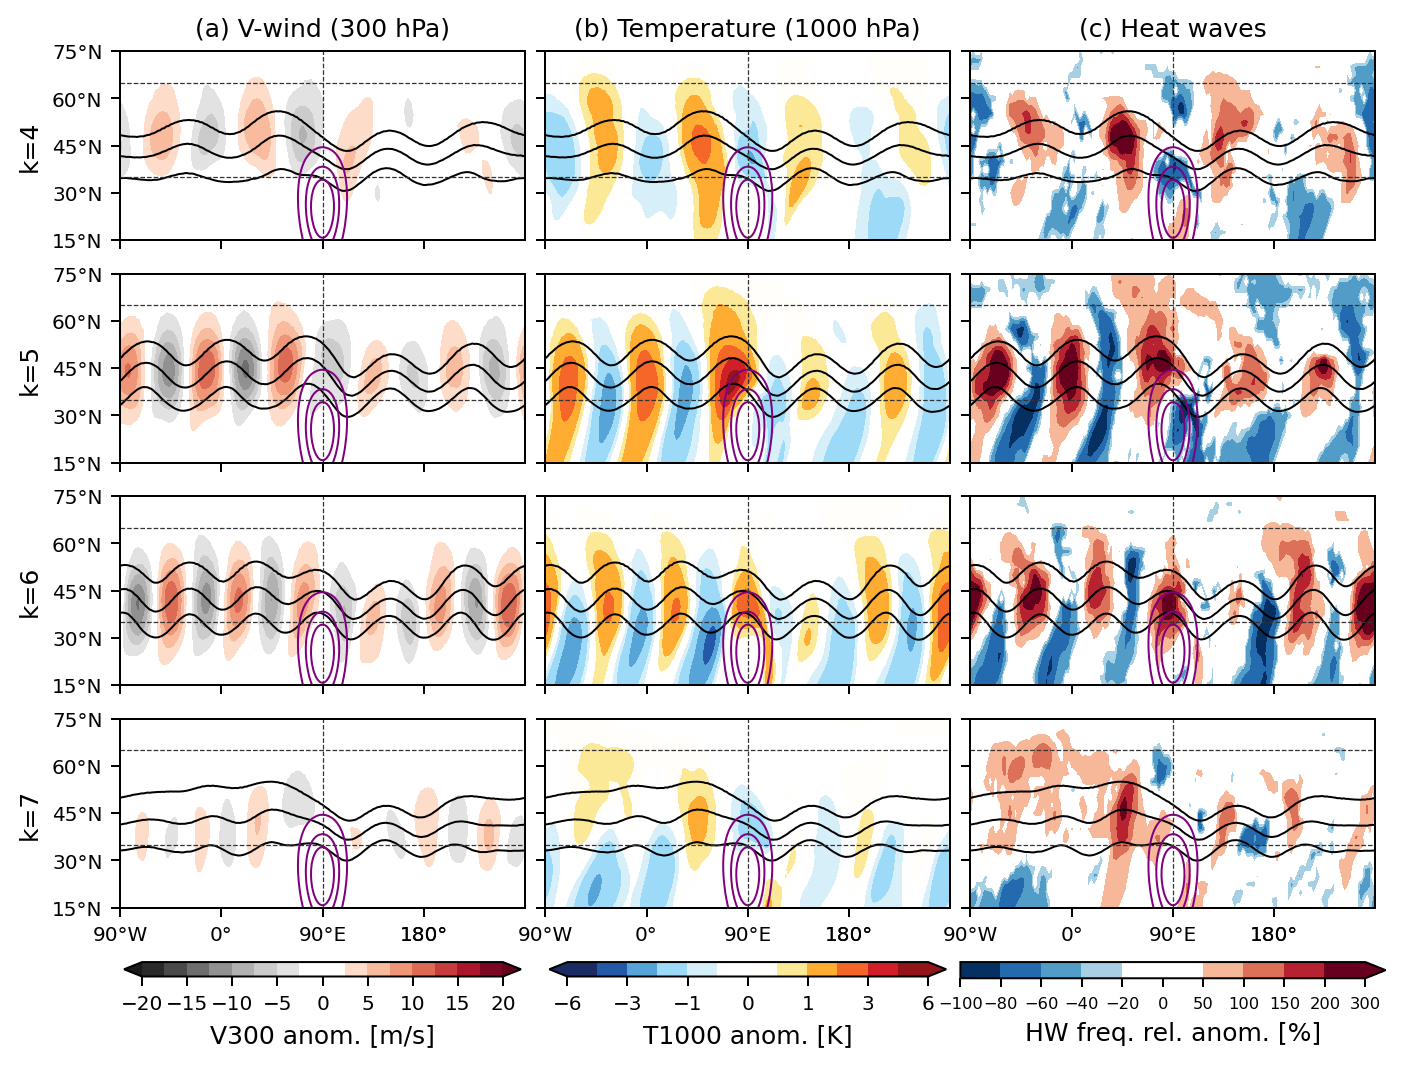

In [18]:
import cartopy.crs as ccrs
import cartopy.util as cutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import cmaps

#define here where topography will be plotted
lat_topo,height_topo = 25, 8 

plt.rcParams['figure.dpi'] = 180
mpl.rcParams['figure.figsize'] = 9, 8
f, axes = plt.subplots(4,3, sharey= True, sharex=True, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=90.0, globe=None)))
axes = axes.flatten()

#---------------------------------------------------
nLons = np.arange(-180,181,90)
nLats = np.arange(-90,91,15)
for ax in axes:
    ax.set_xticks(nLons, crs=ccrs.PlateCarree());
    ax.set_yticks(nLats, crs=ccrs.PlateCarree());
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([15,75])
    
    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    ax.axvline(0, color='0.2',ls="--", lw=0.5)
    ax.axhline(65, color='0.2',ls="--", lw=0.5)
    ax.axhline(35, color='0.2',ls="--", lw=0.5)

    ax.set_aspect(2.8)
#---------------------------------------------------

#
levels = np.arange(-20,20.1,2.5)
levels2 = np.arange(-3,3.1,0.25)
levels3 = np.arange(-10,10.1,1.0)

lat, lon = v_anom_comp.lat, v_anom_comp.lon

colors1 = mpl.cm.get_cmap('RdGy_r', 256)
newcolors = colors1(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

levels2 = [-6,-4,-3,-2,-1,-0.5,0,0.5,1,2,3,4,6]
cmap2 = cmaps.BlueWhiteOrangeRed
norm2 = colors.BoundaryNorm(boundaries=levels2, ncolors=256)


colors1 = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors1(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[110:147, :] = white
cmap3 = mpl.colors.ListedColormap(newcolors)
levels_hw =[-100,-80,-60,-40,-20,0,50,100,150,200,300]
norm3 = colors.BoundaryNorm(boundaries=levels_hw, ncolors=256)

#---------------------------------------------------
for i,wn in enumerate([4,5,6,7]):    
    #plot v300
    v_plot = xr.where(v_anom_comp_p.sel(wavenumber=wn)<0.05, v_anom_comp.sel(wavenumber=wn), 0.0)
    DATA, LON = cutil.add_cyclic_point(v_plot,lon)
    h = axes[i*3].contourf(LON, lat, DATA, levels=levels, cmap=newcmap, extend='both', alpha=1.0,
                  transform=ccrs.PlateCarree()) 
    
    #add z300 countours to all the figures
    DATA, LON = cutil.add_cyclic_point(z_anom_comp.sel(wavenumber=wn),lon)
    h11 = axes[i*3].contour(LON, lat, DATA, levels=[8800,9000,9200], colors='k', linewidths=0.8,transform=ccrs.PlateCarree())
    h11 = axes[i*3+1].contour(LON, lat, DATA, levels=[8800,9000,9200], colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
    h12 = axes[i*3+2].contour(LON, lat, DATA, levels=[8800,9000,9200], colors='k', linewidths=0.8, transform=ccrs.PlateCarree())
    
    #plot T1000
    t_plot = xr.where(t_anom_comp_p.sel(wavenumber=wn)<0.05, t_anom_comp.sel(wavenumber=wn), 0.0)
    DATA, LON = cutil.add_cyclic_point(t_plot,lon)
    h1 = axes[i*3+1].contourf(LON, lat, DATA, levels=levels2, cmap=cmap2,  norm=norm2, extend='both', alpha=1.0,
                  transform=ccrs.PlateCarree())
    #plot heatwave relative change
    hw_comp_plot = xr.where(hw_comp_p.sel(wavenumber=wn)<0.05,hw_comp_sm.sel(wavenumber=wn), 0.0) 
    DATA, LON = cutil.add_cyclic_point(hw_comp_plot,hw_comp.lon)
    h2 = axes[i*3+2].contourf(LON, hw_comp.lat, DATA*100, levels=levels_hw, cmap=cmap3, norm=norm3, extend='max', alpha=1.0,
                  transform=ccrs.PlateCarree()) 

#add topography countours:
#the same for all panels (define above to be consistent with the choosen experiment)   
for ax in axes:
    DATA, LON = cutil.add_cyclic_point(height(lat_topo,height_topo),lon)
    h3 = ax.contour(LON, lat, DATA, colors='purple',levels=[1,3,5], linewidths=0.8,
                      transform=ccrs.PlateCarree()) 

#---------------------------------------------------
axes[0].set_title("(a) V-wind (300 hPa)",fontsize=10)
axes[0].set_ylabel("k=4")
axes[1].set_title("(b) Temperature (1000 hPa)",fontsize=10)

axes[2].set_title("(c) Heat waves",fontsize=10)
axes[3].set_ylabel("k=5")
axes[6].set_ylabel("k=6")
axes[9].set_ylabel("k=7")
#---------------------------------------------------

# adjust size
f.subplots_adjust(hspace=0.1, wspace=0.05)

# add common colorbar
cbar1 = plt.colorbar(h,  ax=[axes[[0,3,6,9]]], label='V300 anom. [m/s]', ticks=levels[::2], pad=0.05,orientation='horizontal',shrink=0.98,aspect=25)
cbar2 = plt.colorbar(h1, ax=[axes[[1,4,7,10]]], label='T1000 anom. [K]', ticks=levels2[::2], pad=0.05,orientation='horizontal',shrink=0.98,aspect=25)
cbar3 = plt.colorbar(h2, ax=[axes[[2,5,8,11]]], label='HW freq. rel. anom. [%]', ticks=levels_hw[:], pad=0.05,orientation='horizontal',shrink=1.05,aspect=25)
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)
cbar3.ax.tick_params(labelsize=6.5)

#save figure
plt.savefig(f'figures/high_amplitude_1.5SD_events_V_Z_T_HWanom_composite_HS_{height_topo}km_{lat_topo}N_significance_p005.pdf',bbox_inches='tight')
